# STATS 102
## Class 28

This class seeks to deliver a summative experience based on analysis performed by Prof. Morales for a consulting client in August 2018.  

## Business question: Can you help us predict CAPs?

* The team
* What is a CAP?
* What is a Customer Case?
* Connecting Customer Cases to CAPs
* What are Customer Case Rates?
* What are Customer Case Signals?

### In the end, we created a data set containing customer case rates, signals, and the next three months of CAPs.  Now, we needed to determine if our inputs (customer case rates and/or inputs) could effectively predict future CAPs.

In [48]:
# Making the imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns

# Import data containing rates, signals and future CAPs
pdata = pd.read_csv("simple1.csv", None)
# Creating input vector
X = pdata[["bug_rate","config_rate",
         "rma_rate","bems_rate","init_sev_1_2_rate",
         "diag_rate","sw_not_bug_rate","bug_signal",
         "config_signal","rma_signal","bems_signal",
         "sev_signal","diag_signal","swnb_signal","rrr_signal"]]
# Subset of inputs representing rates
Xr = pdata[["bug_rate","config_rate","rma_rate","bems_rate","init_sev_1_2_rate",
         "diag_rate","sw_not_bug_rate"]]
# Subset of input representing signals
Xs = pdata[["bug_signal","config_signal","rma_signal","bems_signal",
         "sev_signal","diag_signal","swnb_signal","rrr_signal"]]
# Creating label vector
y = pdata["predict_cap_y"]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


## Visualizing the Data

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


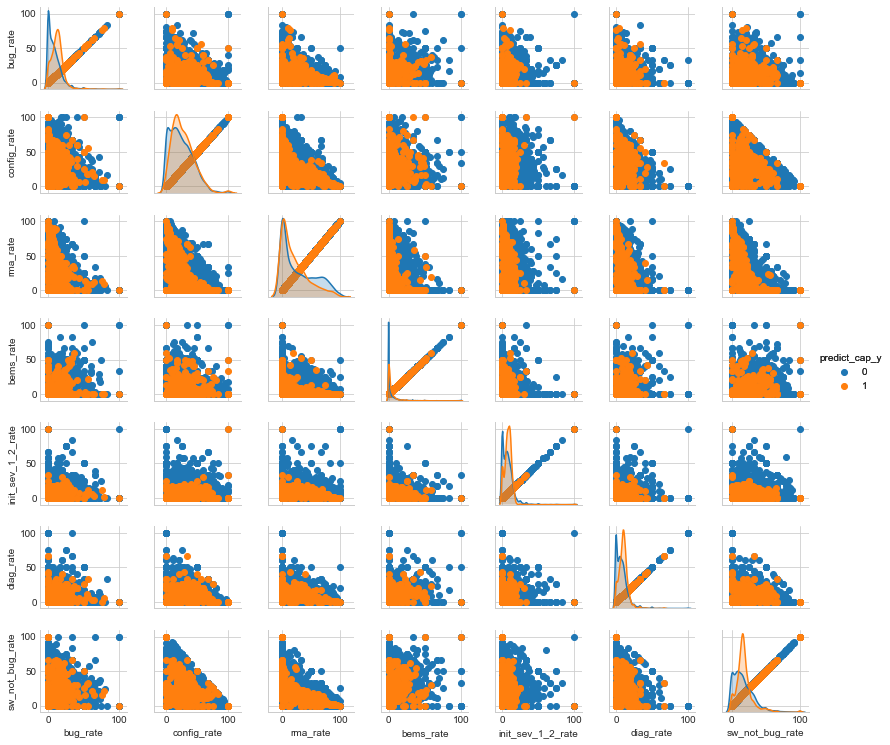

In [49]:
#################################################
# First, let's see all input pair relationships #
#################################################

g = sns.pairplot(pdata, vars=["bug_rate","config_rate","rma_rate"
                              ,"bems_rate","init_sev_1_2_rate","diag_rate"
                              ,"sw_not_bug_rate"],hue='predict_cap_y', size=1.5)
g.map(plt.scatter)
g.add_legend();

# End of program

In [50]:
# Shape of input vector (all variables)
# 15 input variables
X.shape

(8736, 15)

In [51]:
# Shape of input vector (rates only)
# 7 input variables
Xr.shape

(8736, 7)

In [52]:
# Shape of input vector (signals only)
# 8 input variables
Xs.shape

(8736, 8)

In [53]:
# Shape of output vector
# 8736 rows
y.shape

(8736,)

## Dimensionality Reduction 
### Principal Component Analysis

### We'll reduce the dimensions to 2

In [54]:
# Dimensionality Redux Using PCA (all data)
from sklearn.decomposition import PCA  # 1. Choose the model class
model = PCA(n_components=2)            # 2. Instantiate the model with hyperparameters
model.fit(X)                      # 3. Fit to data. Notice y is not specified (no labels!)
X_2D = model.transform(X)         # 4. Transform the data to two dimensions

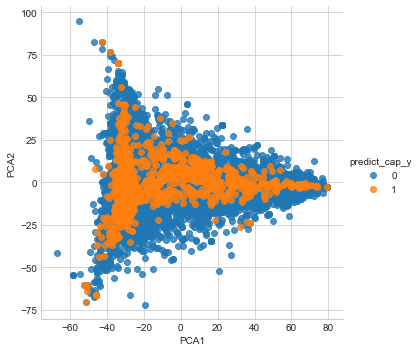

In [55]:
pdata['PCA1'] = X_2D[:, 0] # First feature
pdata['PCA2'] = X_2D[:, 1] # Second feature
sns.lmplot("PCA1", "PCA2", hue='predict_cap_y', data=pdata, fit_reg=False);

### Bottom line, it seems to identify a region for Cap escalations, but not conclusive.  We'll try another method.

## Dimensionality Reduction 
### Isomap

### We'll reduce the dimensions to 2

In [56]:
from sklearn.manifold import Isomap # Choose
iso = Isomap(n_components=2) # Instantiate
iso.fit(X) # Fit
data_projected = iso.transform(X) # Predict
data_projected.shape

(8736, 2)

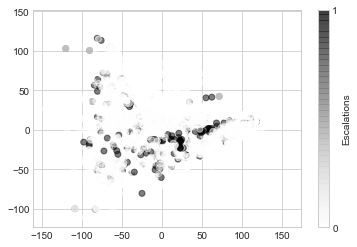

In [57]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=y, alpha=0.5)
plt.colorbar(label='Escalations', ticks=range(4));

### Again, it seems to identify a hotter region for escalations to occur.  So at this point, we are optimistic that we could create an effective classifier.

## Sklearn Gaussian NB Model

In [58]:
## # Trying a different model now
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

for i in range(3):
    # Select input set (X = all, Xr = rates only, Xs = signals only)
    if (i==0): Xin = X
    if (i==1): Xin = Xr
    if (i==2): Xin = Xs
    Xtrain, Xtest, ytrain, ytest = train_test_split(Xin, y,
                                                random_state=1)
    # Predict
    from sklearn.naive_bayes import GaussianNB # 1. choose model class
    model = GaussianNB()                       # 2. instantiate model
    
    model.fit(Xtrain, ytrain)                        # 3. fit model to data
    y_model = model.predict(Xtest)                   # 4. predict on new data

    # Measure accuracy
    from sklearn.metrics import accuracy_score
    acc=accuracy_score(ytest, y_model)
    if (i==0):
        val="GaussianNB"
        print("Model Performance using {}".format(val))
        print("The accuracy using All data is {}%".format(np.round(100*acc,2)))
    if (i==1):
        print("The accuracy using Rate data is {}%".format(np.round(100*acc,2)))
    if (i==2):
        print("The accuracy using Signal data is {}%".format(np.round(100*acc,2)))

Model Performance using GaussianNB
The accuracy using All data is 77.61%
The accuracy using Rate data is 87.09%
The accuracy using Signal data is 78.39%


## Sklearn Logistic Regression Model

In [59]:
## # Trying a different model now
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

for i in range(3):
    # Select input set (X = all, Xr = rates only, Xs = signals only)
    if (i==0): Xin = X
    if (i==1): Xin = Xr
    if (i==2): Xin = Xs
    Xtrain, Xtest, ytrain, ytest = train_test_split(Xin, y,
                                                random_state=1)
    # Predict
    from sklearn.linear_model import LogisticRegression # 1. choose model class
    
    model = LogisticRegression()                          # 2. instantiate model
    model.fit(Xtrain, ytrain)                        # 3. fit model to data
    y_model = model.predict(Xtest)                   # 4. predict on new data

    # Measure accuracy
    from sklearn.metrics import accuracy_score
    acc=accuracy_score(ytest, y_model)
    if (i==0):
        val="LogisticRegression"
        print("Model Performance using {}".format(val))
        print("The accuracy using All data is {}%".format(np.round(100*acc,2)))
    if (i==1):
        print("The accuracy using Rate data is {}%".format(np.round(100*acc,2)))
    if (i==2):
        print("The accuracy using Signal data is {}%".format(np.round(100*acc,2)))

Model Performance using LogisticRegression
The accuracy using All data is 87.18%
The accuracy using Rate data is 87.0%
The accuracy using Signal data is 87.13%


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Sklearn MLP Model

In [60]:
## # Trying a different model now
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

for i in range(3):
    # Select input set (X = all, Xr = rates only, Xs = signals only)
    if (i==0): Xin = X
    if (i==1): Xin = Xr
    if (i==2): Xin = Xs
    Xtrain, Xtest, ytrain, ytest = train_test_split(Xin, y,
                                                random_state=1)
    # Predict
    from sklearn.neural_network import MLPClassifier # 1. choose model class
    
    model = MLPClassifier()                          # 2. instantiate model
    model.fit(Xtrain, ytrain)                        # 3. fit model to data
    y_model = model.predict(Xtest)                   # 4. predict on new data

    # Measure accuracy
    from sklearn.metrics import accuracy_score
    acc=accuracy_score(ytest, y_model)
    if (i==0):
        val="MLPClassifier"
        print("Model Performance using {}".format(val))
        print("The accuracy using All data is {}%".format(np.round(100*acc,2)))
    if (i==1):
        print("The accuracy using Rate data is {}%".format(np.round(100*acc,2)))
    if (i==2):
        print("The accuracy using Signal data is {}%".format(np.round(100*acc,2)))

Model Performance using MLPClassifier
The accuracy using All data is 87.96%
The accuracy using Rate data is 87.82%
The accuracy using Signal data is 86.81%


## TF Logistic Regression Model

In [61]:
# Making the imports
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

# Import data
pdata = pd.read_csv("simple1.csv", None)
# Creating input vector
Xa = pdata[["bug_rate","config_rate",
         "rma_rate","bems_rate","init_sev_1_2_rate",
         "diag_rate","sw_not_bug_rate","bug_signal",
         "config_signal","rma_signal","bems_signal",
         "sev_signal","diag_signal","swnb_signal","rrr_signal"]]
Xa1 = Xa.values
Xr = pdata[["bug_rate","config_rate","rma_rate","bems_rate","init_sev_1_2_rate",
         "diag_rate","sw_not_bug_rate"]]
Xr1 = Xr.values
Xs = pdata[["bug_signal","config_signal","rma_signal","bems_signal",
         "sev_signal","diag_signal","swnb_signal","rrr_signal"]]
Xs1 = Xs.values
# Creating label vector

y = pdata["predict_cap_y"]
y1 = y.values

#from sklearn.cross_validation import train_test_split
# Select desired data set (Xa1, Xr1, or Xs1)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xr1, y1,
                                                random_state=1)

# Determine size of training set

n=Xtrain.shape[1]

# Defining a function to select a batch of "num" random samples

def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]

    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]
    da = np.asarray(data_shuffle)
    dl = np.asarray(labels_shuffle)
    dl = dl[:,np.newaxis]
    return da, dl

tf.reset_default_graph()

# Define Placeholders

X = tf.placeholder(tf.float32, [None, n])
y = tf.placeholder(tf.float32, [None, 1])

# Define Placeholders
 
W = tf.Variable(tf.truncated_normal([n, 1], stddev=0.1))
b = tf.Variable(tf.zeros([1]))

# Training Parameters

learning_rate = 0.03
training_epochs = 3000
batch_size = 20

# Hypothesis 

scores = (tf.matmul(X,  W) + b)
    
# Loss and optimization 

loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(y, scores))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_one_step = optimizer.minimize(loss)

# Accuracy
### Is Scores (prediction) matching output labels?
correct_predictions = tf.equal(tf.nn.relu(scores), y)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# Global Variables Initializer 
init = tf.global_variables_initializer() 

# Training
sess = tf.Session()
sess.run(init)
        
# Iterating through all the epochs 
for i in range(training_epochs):
        X_batch, y_batch = next_batch(batch_size,Xtrain, ytrain)
        sess.run(train_one_step, feed_dict={X: X_batch, y: y_batch})
        ### Find coefficients that minimize loss for mini batch
        if i % 500 == 0:
            training_loss, training_acc = sess.run([loss, accuracy], feed_dict={X: X_batch, y: y_batch})
            #print("Iter", i, "loss =", training_loss, "acc on training set =", training_acc)      

# Storing necessary values to be used outside the Session 
weight = sess.run(W)
bias = sess.run(b) 
     
# Make sure to print out your accuracy on the test set at the end.
val="Logistic Regression Classifier"
print("Model Performance using {}".format(val))
print("Final accuracy on test set:", sess.run(100*accuracy, feed_dict={X: Xtest, y: ytest[:,np.newaxis]}))  

sess.close()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  


Model Performance using Logistic Regression Classifier
Final accuracy on test set: 87.04212


## TF Multi-Layer Perceptron (MLP) Model

In [62]:
##### Making the imports
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from sklearn.model_selection import train_test_split

# Import data
pdata = pd.read_csv("simple1.csv", None)
# Creating input vector
# All Data
Xa = pdata[["bug_rate","config_rate",
         "rma_rate","bems_rate","init_sev_1_2_rate",
         "diag_rate","sw_not_bug_rate","bug_signal",
         "config_signal","rma_signal","bems_signal",
         "sev_signal","diag_signal","swnb_signal","rrr_signal"]]
Xa1 = Xa.values
# Using Rates Only
Xr = pdata[["bug_rate","config_rate","rma_rate","bems_rate","init_sev_1_2_rate",
         "diag_rate","sw_not_bug_rate"]]
Xr1 = Xr.values
# Using Signals Onlt
Xs = pdata[["bug_signal","config_signal","rma_signal","bems_signal",
         "sev_signal","diag_signal","swnb_signal","rrr_signal"]]
Xs1 = Xs.values
# Creating label vector

y = pdata["predict_cap_y"]
y1 = y.values

#from sklearn.cross_validation import train_test_split
# Select desired data set (Xa1, Xr1, or Xs1)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xa1, y1,
                                                random_state=1)

# Determine size of training set

n=Xtrain.shape[1]

# Defining a function to select a batch of "num" random samples

def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]

    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]
    da = np.asarray(data_shuffle)
    dl = np.asarray(labels_shuffle)
    dl = dl[:,np.newaxis]
    return da, dl


# Training Parameters

learning_rate = 0.1 # 0.1
training_epochs = 3000
batch_size = 20

# Neural Network Parameters

n_hidden_1 = 15 # 1st layer number of neurons (15)
n_hidden_2 = 100 # 2nd layer number of neurons (10)
n_input = n # Input data variables 
n_classes = 1 

tf.reset_default_graph()

# Variables
W1 = tf.Variable(tf.truncated_normal([n_input, n_hidden_1], stddev=0.1))
b1 = tf.Variable(tf.zeros([n_hidden_1]))
W2 = tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.1))
b2 = tf.Variable(tf.zeros([n_hidden_2]))
W3 = tf.Variable(tf.truncated_normal([n_hidden_2, n_classes], stddev=0.1))
b3 = tf.Variable(tf.zeros([n_classes]))

# Placeholders
X = (tf.placeholder(tf.float32, [None, n_input]))
y = tf.placeholder(tf.float32, [None, n_classes])

# MLP
h1 = tf.nn.relu(tf.matmul(X,  W1) + b1)
h2 = tf.nn.relu(tf.matmul(h1, W2) + b2)
scores = (tf.matmul(h2, W3) + b3)

# Loss and optimization using Mean Squared Error Cost Function 
loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(y, scores))

train_one_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#train_one_step = optimizer.minimize(loss)

# Accuracy
### Is Scores (prediction) matching output labels?
correct_predictions = tf.equal(tf.nn.relu(scores),y)
#correct_predictions = tf.equal(np.round(scores),y)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# Initialization
init = tf.global_variables_initializer()

# Training
sess = tf.Session()
sess.run(init)

for i in range(training_epochs):
   
    X_batch, y_batch = next_batch(batch_size, Xtrain, ytrain)
    sess.run(train_one_step, feed_dict={X: X_batch, y: y_batch})
    #if i % 1000 == 0:
    #    training_loss, training_acc = sess.run([loss, accuracy], feed_dict={X: X_batch, y: y_batch})
    #    print("Iter", i, "loss =", training_loss, "acc =", training_acc)
       
# Storing necessary values to be used outside the Session 
weight1 = sess.run(W1)
bias1 = sess.run(b1)
weight2 = sess.run(W2)
bias2 = sess.run(b2)       
weight3 = sess.run(W3)
bias3 = sess.run(b3) 
# Make sure to print out your accuracy on the test set at the end.
#print("Final accuracy on training set:", sess.run(100*accuracy, feed_dict={X: Xtrain, y: ytrain[:,np.newaxis]})) 
val="MultiLayer Perceptron Classifier"
print("Model Performance using {}".format(val))
print("Final accuracy on test set:", sess.run(100*accuracy, feed_dict={X: Xtest, y: ytest[:,np.newaxis]})) 
sess.close()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  if sys.path[0] == '':


Model Performance using MultiLayer Perceptron Classifier
Final accuracy on test set: 87.08791


## Analysis Summary

* We studied product quality data to see if we could use it to predict customer escalations
* We created a dataset that contained rates, signals and future CAPs
* We started visualizing all data, but it was hard to get much out of that.  
* We decided to try dimensionality reduction to improve visualization. Using both PCA and Isomap.  We concluded that there was a region where most of escalations tended to congregate.  That findings made us feel confident that we could build an effective classifier.
* We then used three different models in Sklearn library (Gaussian NB, Logistic Regression and MLP) and we got a consistent 87% accuracy in predicting customer escalations.
* We tried the full set as well as subsets of input variables.  We found that rates data was sufficiently predictive, so we decided not to use all inputs.
* We also tried two different models (Logistic Regression and MLP) using Tensorflow library.  Once again, we got 87% accuracy.
* In conclusion, using Logistics Regression model using subset of inputs (rates) provided the best balance between performance and complexity

## Final Note from Prof. Morales
That's ALL folks!!!  This is the end of our journey that started on January 6.  Hope you enjoyed this experience and that we delivered to your expectations of this class.  We certainly faced some challenges with the transition to in-class to online half way through our session.  But in the end, I feel comfortable that we were able to fullfill the learning objectives of this class.  Please stay in touch.  Best Regards, Prof. Morales